Need access to an A100 GPU.

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:

!pip install -q -U bitsandbytes
!pip install -q -U git+https://github.com/huggingface/transformers.git
!pip install -q -U git+https://github.com/huggingface/peft.git
!pip install -q -U git+https://github.com/huggingface/accelerate.git
!pip install -q -U datasets scipy ipywidgets matplotlib
!pip install -q wandb -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.8/119.8 MB 12.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.4/297.4 kB 6.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 46.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.4/139.4 kB 19.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 102.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 17.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━

In [3]:
from datasets import load_dataset

#V1 model
"""
train_dataset = load_dataset('json', data_files='/content/drive/MyDrive/Arunadiss/main/Finetune/dataset/train.jsonl', split='train')
eval_dataset = load_dataset('json', data_files='/content/drive/MyDrive/Arunadiss/main/Finetune/dataset/validation.jsonl', split='train')
"""

#V3 model with new dataset
train_dataset = load_dataset('json', data_files='/content/drive/MyDrive/Arunadiss/main/Finetune/dataset/v2_dataset/train.jsonl', split='train')
eval_dataset = load_dataset('json', data_files='/content/drive/MyDrive/Arunadiss/main/Finetune/dataset/v2_dataset/validation.jsonl', split='train')

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

In [4]:
from accelerate import FullyShardedDataParallelPlugin, Accelerator
from torch.distributed.fsdp.fully_sharded_data_parallel import FullOptimStateDictConfig, FullStateDictConfig

fsdp_plugin = FullyShardedDataParallelPlugin(
    state_dict_config=FullStateDictConfig(offload_to_cpu=True, rank0_only=False),
    optim_state_dict_config=FullOptimStateDictConfig(offload_to_cpu=True, rank0_only=False),
)

accelerator = Accelerator(fsdp_plugin=fsdp_plugin)


Use Weights & Biases to track our training metrics (`wandb`).

In [5]:
import wandb, os
wandb.login()

wandb_project = "diss-biomistral-DARE-v3-finetune"
if len(wandb_project) > 0:
    os.environ["WANDB_PROJECT"] = wandb_project

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


###Formatting prompts
Create a `formatting_func` to structure training examples as prompts. The current dataset has a input formatted as a question, and output is the answer. This function takes an example containing an input question and its corresponding output answer. It formats them into a structured prompt where the question is prefixed with "### Question:" and the answer is prefixed with "### Answer:". This way, the model can understand the structure of the input and output in relation to each other.


In [6]:
"""def formatting_func(example):
    text = f"### Question: {example['input']}\n ### Answer: {example['output']}"
    return text"""
def formatting_func(example):
    text = f"Question: {example['input']}\n\n Answer: {example['output']}"
    return text

### Load Base Model

Load Mistral - BioMistral/BioMistral-7B-DARE - using 4-bit quantization from huggingface

In [7]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

base_model_id = "BioMistral/BioMistral-7B-DARE"
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

model = AutoModelForCausalLM.from_pretrained(base_model_id, quantization_config=bnb_config, device_map="auto")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/651 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/22.8k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.94G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/4.54G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

### Tokenization

Set up the tokenizer. Add padding on the left as it [makes training use less memory](https://ai.stackexchange.com/questions/41485/while-fine-tuning-a-decoder-only-llm-like-llama-on-chat-dataset-what-kind-of-pa).

To decide the `model_max_length` for our input tensors, we should first understand the distribution of our current data's length's. We want to know how many tokens are in each of our prompts. Once we visualize this distribution, we can then decide `model_max_length`.

In [8]:
tokenizer = AutoTokenizer.from_pretrained(
    base_model_id,
    padding_side="left",
    add_eos_token=True,
    add_bos_token=True,
)
tokenizer.pad_token = tokenizer.eos_token

def generate_and_tokenize_prompt(prompt):
    return tokenizer(formatting_func(prompt))


tokenizer_config.json:   0%|          | 0.00/1.47k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

In [9]:
tokenized_train_dataset = train_dataset.map(generate_and_tokenize_prompt)
tokenized_val_dataset = eval_dataset.map(generate_and_tokenize_prompt)

Map:   0%|          | 0/3408 [00:00<?, ? examples/s]

Map:   0%|          | 0/379 [00:00<?, ? examples/s]

3787


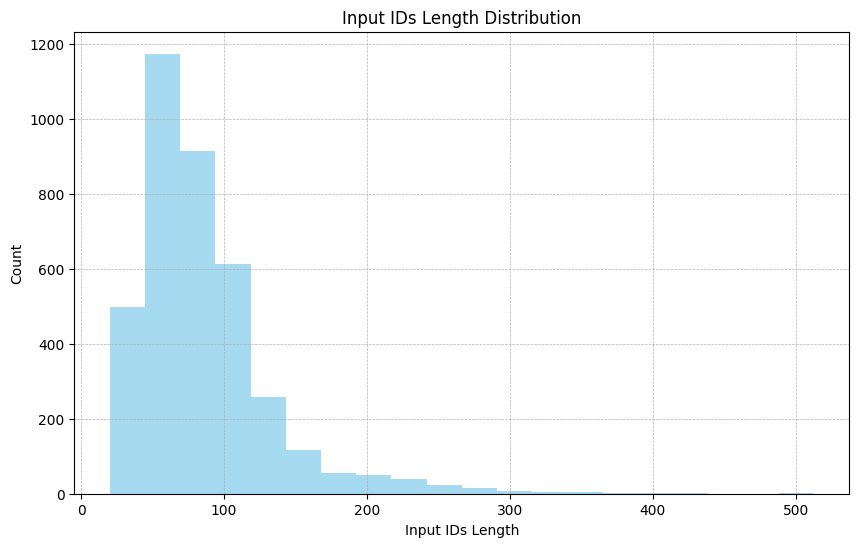

In [11]:

import matplotlib.pyplot as plt

def display_input_id_distribution(train_dataset, val_dataset):
    # Combining and calculating lengths in one step
    all_lengths = [len(record['input_ids']) for dataset in [tokenized_train_dataset, tokenized_val_dataset] for record in dataset]
    print(len(all_lengths))

    # Plotting with a slight style variation
    plt.figure(figsize=(10, 6))
    plt.hist(all_lengths, bins=20, alpha=0.75, color='skyblue')
    plt.xlabel('Input IDs Length')
    plt.ylabel('Count')
    plt.title('Input IDs Length Distribution')
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.show()

display_input_id_distribution(tokenized_train_dataset, tokenized_val_dataset)

In [12]:
# Assuming all_lengths is already calculated as before
all_lengths = [len(record['input_ids']) for dataset in [tokenized_train_dataset, tokenized_val_dataset] for record in dataset]

# Filtering lengths greater than 200 and counting them
lengths_above_200 = [length for length in all_lengths if length > 200]
print(f"Number of inputs with length of input_ids above 200: {len(lengths_above_200)}")

# Filtering lengths greater than 300 and counting them
lengths_above_256 = [length for length in all_lengths if length > 300]
print(f"Number of inputs with length of input_ids above 300: {len(lengths_above_256)}")


Number of inputs with length of input_ids above 200: 136
Number of inputs with length of input_ids above 300: 19


As we can see, almost all of our inputs have less than 300 tokens. Hence, we will pad inputs to 300, and truncate the inputs that have more than 300 to 300 tokens.

Now tokenize with padding and truncation, and set up the tokenize function to make labels and input_ids the same.

In [13]:
max_length = 300

def generate_and_tokenize_prompt2(prompt):
    result = tokenizer(
        formatting_func(prompt),
        truncation=True,
        max_length=max_length,
        padding="max_length",
    )
    result["labels"] = result["input_ids"].copy()
    return result

In [14]:
tokenized_train_dataset = train_dataset.map(generate_and_tokenize_prompt2)
tokenized_val_dataset = eval_dataset.map(generate_and_tokenize_prompt2)

Map:   0%|          | 0/3408 [00:00<?, ? examples/s]

Map:   0%|          | 0/379 [00:00<?, ? examples/s]

As we can see `input_ids` is padded on the left with the `eos_token` (2). Once the padding with (2)'s is finished, before the prompt starts, a `bos_token` is inserted, then the prompt is tokenized, and then finished with one more `eos_token`.

In [15]:
print(tokenized_train_dataset[1]['input_ids'])
print(tokenized_train_dataset[1]['input'])

[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 22478, 28747, 1824, 460, 272, 1945, 3926, 1938, 272, 430, 19525, 5430, 302, 2367, 9795, 28804, 13, 13, 26307, 28747, 6213, 272, 430, 19525, 302, 2367, 9795, 28725, 16007, 2195, 1115, 4544, 304, 24448, 385, 28548, 2076, 1058, 28725, 7888, 9141, 916, 264, 7817, 6794, 28723, 689, 436, 385, 28548, 28725, 14333, 2458, 302, 2652, 299, 1944, 15792, 5668, 24448, 270, 2298, 28725, 460, 7298, 438, 264, 1595, 436, 397, 28723, 8144, 1360, 1595, 2737, 28548, 2318, 298, 272, 9089, 1160, 274, 302, 272, 3601, 304, 1221, 

Now all the samples should be the same length, `max_length`.

3787


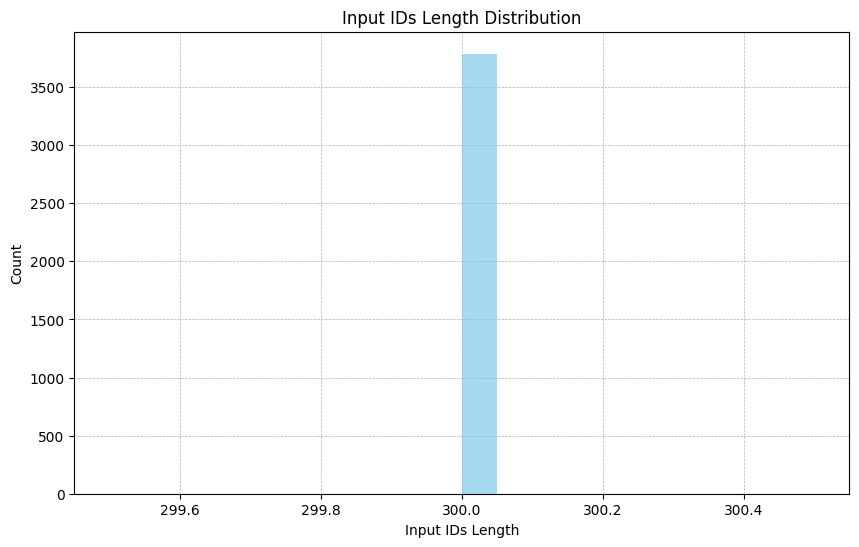

In [16]:
display_input_id_distribution(tokenized_train_dataset, tokenized_val_dataset)

### Biomistral Base model on three eval_prompts

Just to get a quick unofficial idea of how fine tuned model does versus the vanilla model, we can print a few mistral generations using three eval prompts. One that tests its ability on understanding specific topics, one paper 2 question, and a multiple choice paper 1 question.

In [ ]:
eval_prompt_1 = "Question: What is the Davson-Danielli model?"
#Completion: The Davson-Danielli model is a lipo-protein sandwich model that assumed all membranes were of a uniform thickness with a constant lipid-protein ratio, and it assumed all membranes would have symmetrical internal and external surfaces. It did not account for the permeability of certain substances and did not recognize the need for hydrophilic pores. The temperatures at which membranes solidified did not correlate with those expected under this model."

eval_prompt_2="Question:What is the role of cells in the defence against infectious disease? [7 marks]"
"""
Output: Answer:

Cells of skin provide a physical barrier/produce fatty acids/lactic acid/lysozyme which stops entry of microbes, or mucous membranes produce mucus to trap pathogens. Also, stomach cells produce hydrochloric acid which kills microbes.
Platelets start the clotting process preventing access of pathogens.
Two types of white blood cells fight infections in the body.
Phagocytes ingest pathogens by endocytosis/phagocytosis and give non-specific immunity to diseases.
Antibodies are produced by lymphocytes/B cells in response to particular pathogens/antigens, giving specific immunity.
Lymphocyte/B cell makes only one type of antibody, and plasma cells produce a large quantity of one type of antibody.
Some lymphocytes act/remain as memory cells and can quickly reproduce to form a clone of plasma cells if a pathogen carrying a specific antigen is re-encountered, resulting in faster defence against second exposure to specific antigen/pathogen/disease."""

eval_prompt_3="""Question:What is an example of the therapeutic use of stem cells?

A. Sequencing the human genome
B. Forensic investigations of paternity
C. Production of genetically modified crops
D. Restoration of insulation tissue in neurons
Answer with only the correct letter!
Answer:"""
#D

In [ ]:
# Init an eval tokenizer that doesn't add padding or eos token
eval_tokenizer = AutoTokenizer.from_pretrained(
    base_model_id,
    add_bos_token=True,
)

model_input_1 = eval_tokenizer(eval_prompt_1, return_tensors="pt").to("cuda")

model.eval()
with torch.no_grad():
    print(f"Eval 1:\n\n")
    print(eval_tokenizer.decode(model.generate(**model_input_1, max_new_tokens=100, repetition_penalty=1.15)[0], skip_special_tokens=True))
    print(f"\n\n")


model_input_2 = eval_tokenizer(eval_prompt_2, return_tensors="pt").to("cuda")

model.eval()
with torch.no_grad():
    print(f"Eval 2:\n\n")
    print(eval_tokenizer.decode(model.generate(**model_input_2, max_new_tokens=100, repetition_penalty=1.15)[0], skip_special_tokens=True))
    print(f"\n\n")


model_input_3 = eval_tokenizer(eval_prompt_3, return_tensors="pt").to("cuda")

model.eval()
with torch.no_grad():
    print(f"Eval 3:\n\n")
    print(eval_tokenizer.decode(model.generate(**model_input_3, max_new_tokens=20, repetition_penalty=1.15)[0], skip_special_tokens=True))
    print(f"\n\n")


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Eval 1:




Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Question: What is the Davson-Danielli model?
Answer: The Davson-Danielli model, also known as the bilayer model or the Davson model, is a widely accepted theoretical framework for understanding the structure and function of biological membranes. It was proposed by Davson and Danielli in 1946 based on electron microscopy studies of cellular membranes. According to this model, biological membranes are composed of two layers of phospholipids that form a lipid bilayer. Each



Eval 2:




Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Question:What is the role of cells in the defence against infectious disease? [7 marks] Cells play a crucial role in defending our bodies against infectious diseases. They are responsible for identifying and destroying foreign invaders such as bacteria, viruses, fungi and parasites that enter our body. This process is known as immunity. There are two main types of immune response; innate and acquired. The innate immune system provides an immediate response to infection and includes physical barriers like skin and mucous membranes, chemical barriers like stomach acid and enzymes in tears and



Eval 3:


Question:What is an example of the therapeutic use of stem cells?

A. Sequencing the human genome
B. Forensic investigations of paternity
C. Production of genetically modified crops
D. Restoration of insulation tissue in neurons
Answer with only the correct letter!
Answer: D





### 4. Set Up LoRA

Apply  preprocessing to Mistral in order to prepare it for training. For that we use the `prepare_model_for_kbit_training` method from PEFT.

In [17]:
from peft import prepare_model_for_kbit_training

model.gradient_checkpointing_enable()
model = prepare_model_for_kbit_training(model)

In [18]:
def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
    )

In [19]:
from peft import LoraConfig, get_peft_model

config = LoraConfig(
    r=16,#32,
    lora_alpha=32,#64,
    target_modules=[
        "q_proj",
        "k_proj",
        "v_proj",
        "o_proj",
        "gate_proj",
        "up_proj",
        "down_proj",
        "lm_head",
    ],
    bias="none",
    use_rslora=True,
    lora_dropout=0.05,  # Conventional
    task_type="CAUSAL_LM",
)

model = get_peft_model(model, config)
print_trainable_parameters(model)

trainable params: 42520576 || all params: 3794591744 || trainable%: 1.1205573318192514


### Training

In [20]:
if torch.cuda.device_count() > 1: # If more than 1 GPU
    model.is_parallelizable = True
    model.model_parallel = True

In [21]:
model = accelerator.prepare_model(model)

In [22]:
import torch
print(torch.__version__)
print(torch.version.cuda)

!nvidia-smi


2.2.1+cu121
12.1
Tue Apr 16 11:59:06 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off | 00000000:00:04.0 Off |                    0 |
| N/A   30C    P0              47W / 400W |   6247MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+--------

In [23]:
import transformers
from datetime import datetime

#project = "ib-bio-v3" #this was the last run for mistral v1
project = "ib-bio-v1"
base_model_name = "biomistral-dare-v3"
run_name = base_model_name + "-" + project
#output_dir = "./" + run_name
output_dir= "/content/drive/MyDrive/Arunadiss/main/Finetune/model/biomistral-dare/logs/"+ run_name
logging_dir="/content/drive/MyDrive/Arunadiss/main/Finetune/model/biomistral-dare/logs"

# Check if the directory exists
if not os.path.exists(output_dir):
    # Create the directory if it doesn't exist
    os.makedirs(output_dir)

print("Output directory created:", output_dir)

trainer = transformers.Trainer(
    model=model,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_val_dataset,
    args=transformers.TrainingArguments(
        output_dir=output_dir,
        warmup_steps=1,
        per_device_train_batch_size=2,#8,#2,
        gradient_accumulation_steps=1,
        gradient_checkpointing=True,
        #max_steps=-1,#500,#
        num_train_epochs=6,
        learning_rate=2.5e-5, # Want a small lr for finetuning
        bf16=True,
        optim="paged_adamw_8bit",
        logging_steps=25,#25,              # When to start reporting loss
        logging_dir=logging_dir,#"./logs",        # Directory for storing logs
        save_strategy="steps",       # Save the model checkpoint every logging step
        save_steps=250,#25,                # Save checkpoints every 250 steps
        evaluation_strategy="steps", # Evaluate the model every logging step
        eval_steps=250,#25,               # Evaluate 250 steps
        do_eval=True,                # Perform evaluation at the end of training
        report_to="wandb",
        run_name=f"{run_name}-{datetime.now().strftime('%Y-%m-%d-%H-%M')}"          # Name of the W&B run
        #use_reentrant=True  # Explicitly setting use_reentrant to suppress the checkpoint warning
    ),
    data_collator=transformers.DataCollatorForLanguageModeling(tokenizer, mlm=False),
)

model.config.use_cache = False  # silence the warnings
trainer.train()

Output directory created: /content/drive/MyDrive/Arunadiss/main/Finetune/model/biomistral-dare/logs/biomistral-dare-v3-ib-bio-v1


wandb: Currently logged in as: alexkstern (alexksternteam). Use `wandb login --relogin` to force relogin


/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Step,Training Loss,Validation Loss
250,1.394200,1.393556
500,1.356500,1.362929
750,1.302100,1.333613
1000,1.322500,1.318554
1250,1.358900,1.297293
1500,1.229700,1.280904
1750,0.777500,1.324328
2000,0.748100,1.345763
2250,0.723100,1.340079
2500,0.716700,1.352004


/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:158: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:158: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in

TrainOutput(global_step=10224, training_loss=0.4830164673835832, metrics={'train_runtime': 7839.5314, 'train_samples_per_second': 2.608, 'train_steps_per_second': 1.304, 'total_flos': 2.632828290859008e+17, 'train_loss': 0.4830164673835832, 'epoch': 6.0})

In [24]:
wandb.finish()

eval/loss,▂▂▁▁▁▁▁▁▁▂▁▁▁▃▃▃▃▃▃▃▅▅▅▅▅▅▅▆▆▆▆▆▆▆▇█████
eval/runtime,▄▅▄▄▂▆█▃▃▂▄▃▆▆▅▂▁▂▃▂▆▆▂▁█▁▂▂▁▇▇▃▂▁▁▁▁▇▂▂
eval/samples_per_second,▅▄▅▅▆▃▁▆▆▇▅▆▃▃▃▇█▇▆▇▃▃▇█▁█▇▇█▂▂▆▆████▂▇▇
eval/steps_per_second,▅▄▅▅▇▂▁▇▅▇▅▇▂▄▄▇█▇▅▇▂▂▇█▁█▇▇█▂▂▅▇████▂▇▇
train/epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train/grad_norm,▅▄▄▅▃▄▄▄▅▄▆▄▅▆▆▂▅█▅▇▃▆▁▄▅▃▃▃▃▃▁▅▂▂▁▁▁▂▁▅
train/learning_rate,████▇▇▇▇▇▆▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁
train/loss,▇▇▇█▇▇▇▄▄▄▄▄▅▄▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eval/loss,2.24138
eval/runtime,20.1827


As we can see model started to overfit, and eventually validation loss started increasing after step 3900. Hence, we will chose our checkpoint closest to this step.

### Use the Trained Model


In [25]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

base_model_id = "BioMistral/BioMistral-7B-DARE"
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

base_model = AutoModelForCausalLM.from_pretrained(
    base_model_id,  # Mistral, same as before
    quantization_config=bnb_config,  # Same quantization config as before
    device_map="auto",
    trust_remote_code=True,
)

eval_tokenizer = AutoTokenizer.from_pretrained(base_model_id, add_bos_token=True, trust_remote_code=True)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
#model.config.use_cache = True

Now load the QLoRA adapter from the appropriate checkpoint directory, i.e. the best performing model checkpoint:

In [52]:
from peft import PeftModel

path_7250= '/content/drive/MyDrive/Arunadiss/main/Finetune/model/biomistral-dare/logs/biomistral-dare-v3-ib-bio-v1/checkpoint-7250'
path_1500="/content/drive/MyDrive/Arunadiss/main/Finetune/model/biomistral-dare/logs/biomistral-dare-v3-ib-bio-v1/checkpoint-1500"
ft_model = PeftModel.from_pretrained(base_model, path_1500)#'/content/drive/MyDrive/Arunadiss/main/Finetune/model/biomistral-dare/logs/biomistral-dare-v2-ib-bio-v2/checkpoint-5750')

In [37]:
eval_prompt_1 = "Question: Teach me what the Davson-Danielli model is.\nAnswer:"
#Completion: The Davson-Danielli model is a lipo-protein sandwich model that assumed all membranes were of a uniform thickness with a constant lipid-protein ratio, and it assumed all membranes would have symmetrical internal and external surfaces. It did not account for the permeability of certain substances and did not recognize the need for hydrophilic pores. The temperatures at which membranes solidified did not correlate with those expected under this model."

eval_prompt_2="Question:What is the role of cells in the defence against infectious disease? [7 marks]\nAnswer:"
"""
Output: Answer:

Cells of skin provide a physical barrier/produce fatty acids/lactic acid/lysozyme which stops entry of microbes, or mucous membranes produce mucus to trap pathogens. Also, stomach cells produce hydrochloric acid which kills microbes.
Platelets start the clotting process preventing access of pathogens.
Two types of white blood cells fight infections in the body.
Phagocytes ingest pathogens by endocytosis/phagocytosis and give non-specific immunity to diseases.
Antibodies are produced by lymphocytes/B cells in response to particular pathogens/antigens, giving specific immunity.
Lymphocyte/B cell makes only one type of antibody, and plasma cells produce a large quantity of one type of antibody.
Some lymphocytes act/remain as memory cells and can quickly reproduce to form a clone of plasma cells if a pathogen carrying a specific antigen is re-encountered, resulting in faster defence against second exposure to specific antigen/pathogen/disease."""

eval_prompt_3="""Question:What is an example of the therapeutic use of stem cells?

A. Sequencing the human genome
B. Forensic investigations of paternity
C. Production of genetically modified crops
D. Restoration of insulation tissue in neurons

Answer:"""
#D

####V3 dataset Model 1

#####checkpoint-1500

V3 dataset Model 1

In [39]:
model_input_1 = eval_tokenizer(eval_prompt_1, return_tensors="pt").to("cuda")

ft_model.eval()
with torch.no_grad():
    print(f"Eval 1:\n\n")
    print(eval_tokenizer.decode(ft_model.generate(**model_input_1, max_new_tokens=200, repetition_penalty=1.15)[0], skip_special_tokens=True))
    print(f"\n##\n")

model_input_2 = eval_tokenizer(eval_prompt_2, return_tensors="pt").to("cuda")

ft_model.eval()
with torch.no_grad():
    print(f"Eval 2:\n\n")
    print(eval_tokenizer.decode(ft_model.generate(**model_input_2, max_new_tokens=120, repetition_penalty=1.15)[0], skip_special_tokens=True))
    print(f"\n##\n")

model_input_3 = eval_tokenizer(eval_prompt_3, return_tensors="pt").to("cuda")

ft_model.eval()
with torch.no_grad():
    print(f"Eval 3:\n\n")
    print(eval_tokenizer.decode(ft_model.generate(**model_input_3, max_new_tokens=5, repetition_penalty=1.15)[0], skip_special_tokens=True))
    print(f"\n##\n")


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Eval 1:




Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Question: Teach me what the Davson-Danielli model is.
Answer: The Davson-Danielli model, also known as the fluid mosaic model, describes how membranes are structured. It suggests that proteins and lipids are arranged in a random fashion to form a mosaic of components. This model was proposed by James Danielli and Jamesörmöváááááááááááááááááááááááááááááááááááááááááááááááááááááááááááááááááááááááááááááááááááááááááááááááááááááááááááááááááááááááááááááááááááááááá

##

Eval 2:




Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Question:What is the role of cells in the defence against infectious disease? [7 marks]
Answer: - cells are part of the immune system;
- phagocytic leukocytes engulf pathogens/bacteria/pathogen fragments;
- lymphocytes produce antibodies to specific antigens;
- B lymphocytes differentiate into plasma cells and memory cells;
- T lymphocytes activate helper T cells;
- macrophages secrete cytokines that stimulate other immune cells;
- complement proteins form a membrane attack complex (MAC);
- inflammation causes red

##

Eval 3:


Question:What is an example of the therapeutic use of stem cells?

A. Sequencing the human genome
B. Forensic investigations of paternity
C. Production of genetically modified crops
D. Restoration of insulation tissue in neurons

Answer: D. Restoration of

##



In [54]:
eval_prompt= 'What are the three main processes that promote variation within a population?\nAnswer:'
""""The three main processes that promote variation within a population are gene mutations,
which change the genetic composition of an organism due to alterations in the DNA base sequence,
sexual reproduction, which introduces new gene combinations in offspring via random mating and meiotic divisions,
and gene flow, which is the movement of alleles into or out of a population as a result of immigration or emigration."""
model_input_ = eval_tokenizer(eval_prompt, return_tensors="pt").to("cuda")

ft_model.eval()
with torch.no_grad():
    print(f"Eval:\n\n")
    print(eval_tokenizer.decode(ft_model.generate(**model_input_, max_new_tokens=100, repetition_penalty=1.15)[0], skip_special_tokens=True))
    print(f"\n##\n")

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Eval:


What are the three main processes that promote variation within a population?
Answer: The three main processes that promote variation within a population are mutation, gene flow and sexual reproduction. Mutations occur when there is a change to an organism’s DNA sequence. Gene flow occurs when genes move between populations via migration or interbreeding. Sexual reproduction involves the fusion of two gametes from different individuals.

##



In [55]:
eval_prompt= 'Question: Starting from the concept of gene pool, explain briefly how populations of early vertebrates could have evolved into different groups. [3 marks]\nAnswer:'
""""- Gene pool is all genes/all alleles. Reject all alleles/genes in a species.\n
- Geographic isolation Reject isolation if no type of isolation given. OR migration to different areas OR temporal isolation OR behavioural isolation\n
- Speciation/gene pool split if populations are reproductively isolated/do not interbreed\n
- In different environments there are different selection pressures/opportunities/natural selection/adaptations/niches «to exploit»\n
- Allele frequencies change/diverge Reject gene frequencies."""
model_input_ = eval_tokenizer(eval_prompt, return_tensors="pt").to("cuda")

ft_model.eval()
with torch.no_grad():
    print(f"Eval:\n\n")
    print(eval_tokenizer.decode(ft_model.generate(**model_input_, max_new_tokens=120, repetition_penalty=1.15)[0], skip_special_tokens=True))
    print(f"\n##\n")

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Eval:


Question: Starting from the concept of gene pool, explain briefly how populations of early vertebrates could have evolved into different groups. [3 marks]
Answer: - (early) vertebrate populations were geographically separated/isolated
- gene pools became separate due to isolation / no interbreeding between populations
- mutations occurred in each population
- natural selection led to adaptation to local conditions
- speciation occurred when two populations diverged sufficiently
- speciation is a gradual process that occurs over many generations
- speciation can be rapid if there are large environmental changes
- speciation may occur by adaptive radiation
- speciation may result in reproductively isolated populations
- speciation results in

##



In [56]:
eval_prompt= 'Describe how body temperature is maintained in humans. [6 marks]\nAnswer:'
""""- maintained close to 36.7/37°C/98.6°F\n- heat is transferred/distributed in body by blood\n
- hypothalamus contains thermoreceptors\n- hypothalamus monitors temperature/sends message to effectors/causes response\n
- (vaso) dilation of skin arterioles warms skin/cools body\n- (vaso) constriction of skin arterioles retains body heat\n
- skin/sweat glands produce sweat to cool the body when overheated\n- removal of heat through evaporation of sweat\n
- shivering generates heat / increased metabolism / hair erection to retain heat\n
- example of behavioral change to warm/cool the body to thermoregulate"""
model_input_ = eval_tokenizer(eval_prompt, return_tensors="pt").to("cuda")

ft_model.eval()
with torch.no_grad():
    print(f"Eval:\n\n")
    print(eval_tokenizer.decode(ft_model.generate(**model_input_, max_new_tokens=120, repetition_penalty=1.15)[0], skip_special_tokens=True))
    print(f"\n##\n")

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Eval:


Describe how body temperature is maintained in humans. [6 marks]
Answer: - heat produced by metabolic reactions/food digestion/cell respiration;
- heat lost from the body (by radiation, convection and evaporation);
- blood carries heat to skin surface;
- heat exchanged between blood and skin;
- sweat evaporates and cools skin;
- water vapour rises into air;
- hair traps air close to skin;
- shivering increases metabolic rate/heat production;
- hypothalamus controls body temperature;
- body temperature regulated within narrow range

##



In [40]:
eval_prompt_3="""Question:What is an example of the therapeutic use of stem cells?

A. Sequencing the human genome
B. Forensic investigations of paternity
C. Production of genetically modified crops
D. Restoration of insulation tissue in neurons

Answer:"""
model_input_3 = eval_tokenizer(eval_prompt_3, return_tensors="pt").to("cuda")

ft_model.eval()
with torch.no_grad():
    print(f"Eval 3:\n\n")
    print(eval_tokenizer.decode(ft_model.generate(**model_input_3, max_new_tokens=3, repetition_penalty=1.15)[0], skip_special_tokens=True))
    print(f"\n##\n")

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Eval 3:


Question:What is an example of the therapeutic use of stem cells?

A. Sequencing the human genome
B. Forensic investigations of paternity
C. Production of genetically modified crops
D. Restoration of insulation tissue in neurons

Answer: D. Rest

##



#####Checkpoint 7250

V3 dataset Model 1

In [43]:
model_input_1 = eval_tokenizer(eval_prompt_1, return_tensors="pt").to("cuda")

ft_model.eval()
with torch.no_grad():
    print(f"Eval 1:\n\n")
    print(eval_tokenizer.decode(ft_model.generate(**model_input_1, max_new_tokens=200, repetition_penalty=1.15)[0], skip_special_tokens=True))
    print(f"\n##\n")

model_input_2 = eval_tokenizer(eval_prompt_2, return_tensors="pt").to("cuda")

ft_model.eval()
with torch.no_grad():
    print(f"Eval 2:\n\n")
    print(eval_tokenizer.decode(ft_model.generate(**model_input_2, max_new_tokens=120, repetition_penalty=1.15)[0], skip_special_tokens=True))
    print(f"\n##\n")

model_input_3 = eval_tokenizer(eval_prompt_3, return_tensors="pt").to("cuda")

ft_model.eval()
with torch.no_grad():
    print(f"Eval 3:\n\n")
    print(eval_tokenizer.decode(ft_model.generate(**model_input_3, max_new_tokens=5, repetition_penalty=1.15)[0], skip_special_tokens=True))
    print(f"\n##\n")


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Eval 1:




Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Question: Teach me what the Davson-Danielli model is.
Answer: The Davson-Danielli model, also known as the lipo-protein sandwich model, was proposed by Seymour Singer and Garth Nicolson in 1972. It suggested that proteins were sandwiched between two layers of phospholipids. According to this model, all membranes have a uniform thickness and composition, with only minor variations. The model was successful in explaining many phenomena, but it could not account for the fluidity of membranes, as the proteins were thought to be fixed in place. It also could not explain how membrane shape could change, as proteins were thought to be rigid. The model was superseded by the fluid-mosaic model proposed by Seymour Singer and Garth Nicolson in 1976.

##

Eval 2:




Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Question:What is the role of cells in the defence against infectious disease? [7 marks]
Answer: - antibodies are produced faster if infection occurs while T lymphocytes are present
- T lymphocytes activate B lymphocytes
- which then divide and produce more specific B lymphocytes/plasma cells
- plasma cells secrete specific antibodies
- some B lymphocytes act as memory cells
- (all this results in) immunity
- without activation by T lymphocytes, B lymphocytes do not divide/produce antibodies
- cytokines produced

##

Eval 3:


Question:What is an example of the therapeutic use of stem cells?

A. Sequencing the human genome
B. Forensic investigations of paternity
C. Production of genetically modified crops
D. Restoration of insulation tissue in neurons

Answer: D. Restoration of

##



In [48]:
eval_prompt= 'What are the three main processes that promote variation within a population?\nAnswer:'
""""The three main processes that promote variation within a population are gene mutations,
which change the genetic composition of an organism due to alterations in the DNA base sequence,
sexual reproduction, which introduces new gene combinations in offspring via random mating and meiotic divisions,
and gene flow, which is the movement of alleles into or out of a population as a result of immigration or emigration.""""
model_input_ = eval_tokenizer(eval_prompt, return_tensors="pt").to("cuda")

ft_model.eval()
with torch.no_grad():
    print(f"Eval:\n\n")
    print(eval_tokenizer.decode(ft_model.generate(**model_input_, max_new_tokens=100, repetition_penalty=1.15)[0], skip_special_tokens=True))
    print(f"\n##\n")

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Eval:


What are the three main processes that promote variation within a population?
Answer: The three main processes that promote variation within a population are mutations, meiosis and sexual reproduction. Mutations involve changes to the genetic sequence of an organism due to random changes in DNA or the introduction of new alleles via gene transfer. Meiosis is the process by which haploid gametes are created, with the separation of homologous chromosomes leading to different combinations of alleles being inherited. Sexual reproduction involves the fusion of two haplo

##



In [50]:
eval_prompt= 'Question: Starting from the concept of gene pool, explain briefly how populations of early vertebrates could have evolved into different groups. [3 marks]\nAnswer:'
""""- Gene pool is all genes/all alleles. Reject all alleles/genes in a species.\n
- Geographic isolation Reject isolation if no type of isolation given. OR migration to different areas OR temporal isolation OR behavioural isolation\n
- Speciation/gene pool split if populations are reproductively isolated/do not interbreed\n
- In different environments there are different selection pressures/opportunities/natural selection/adaptations/niches «to exploit»\n
- Allele frequencies change/diverge Reject gene frequencies."""
model_input_ = eval_tokenizer(eval_prompt, return_tensors="pt").to("cuda")

ft_model.eval()
with torch.no_grad():
    print(f"Eval:\n\n")
    print(eval_tokenizer.decode(ft_model.generate(**model_input_, max_new_tokens=120, repetition_penalty=1.15)[0], skip_special_tokens=True))
    print(f"\n##\n")

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Eval:


Question: Starting from the concept of gene pool, explain briefly how populations of early vertebrates could have evolved into different groups. [3 marks]
Answer: - (gene pool is) all genes/alleles in a population
- mutation changes alleles/gene pool
- mutations accumulating over generations
- differences in reproductive success (due to environmental pressures)
- natural selection / differential reproduction
- speciation by divergent evolution / gradualism / punctuated equilibrium
- example of speciation through divergent evolution / gradualism / punctuated equilibrium (e.g. homologous structures leading to similar functions; adaptive radiation)
- allosteric regulation / enzymes /

##



In [51]:
eval_prompt= 'Describe how body temperature is maintained in humans. [6 marks]\nAnswer:'
""""- maintained close to 36.7/37°C/98.6°F\n- heat is transferred/distributed in body by blood\n
- hypothalamus contains thermoreceptors\n- hypothalamus monitors temperature/sends message to effectors/causes response\n
- (vaso) dilation of skin arterioles warms skin/cools body\n- (vaso) constriction of skin arterioles retains body heat\n
- skin/sweat glands produce sweat to cool the body when overheated\n- removal of heat through evaporation of sweat\n
- shivering generates heat / increased metabolism / hair erection to retain heat\n
- example of behavioral change to warm/cool the body to thermoregulate"""
model_input_ = eval_tokenizer(eval_prompt, return_tensors="pt").to("cuda")

ft_model.eval()
with torch.no_grad():
    print(f"Eval:\n\n")
    print(eval_tokenizer.decode(ft_model.generate(**model_input_, max_new_tokens=120, repetition_penalty=1.15)[0], skip_special_tokens=True))
    print(f"\n##\n")

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Eval:


Describe how body temperature is maintained in humans. [6 marks]
Answer: - normal body core temp constant (36.5 to 37.5°C)
- regulated by negative feedback/homeostatic mechanisms
- hypothalamus is the centre of thermoregulation
- hypothalamus sends impulses to the body to increase/decrease temperatures
- release of sweat (by sweat glands in the skin) if skin temperature rises
- evaporation of water cools the body (concept of evaporation must be mentioned)
- heat is transferred by blood
- transfer of

##



In [46]:
eval_prompt_3="""Question:What is an example of the therapeutic use of stem cells?

A. Sequencing the human genome
B. Forensic investigations of paternity
C. Production of genetically modified crops
D. Restoration of insulation tissue in neurons

Answer:"""
model_input_3 = eval_tokenizer(eval_prompt_3, return_tensors="pt").to("cuda")

ft_model.eval()
with torch.no_grad():
    print(f"Eval 3:\n\n")
    print(eval_tokenizer.decode(ft_model.generate(**model_input_3, max_new_tokens=3, repetition_penalty=1.15)[0], skip_special_tokens=True))
    print(f"\n##\n")

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Eval 3:


Question:What is an example of the therapeutic use of stem cells?

A. Sequencing the human genome
B. Forensic investigations of paternity
C. Production of genetically modified crops
D. Restoration of insulation tissue in neurons

Answer: D. Rest

##



####Previous Models

V2 dataset 2 Model

In [ ]:
model_input_1 = eval_tokenizer(eval_prompt_1, return_tensors="pt").to("cuda")

ft_model.eval()
with torch.no_grad():
    print(f"Eval 1:\n\n")
    print(eval_tokenizer.decode(ft_model.generate(**model_input_1, max_new_tokens=100, repetition_penalty=1.15)[0], skip_special_tokens=True))
    print(f"\n##\n")

model_input_2 = eval_tokenizer(eval_prompt_2, return_tensors="pt").to("cuda")

ft_model.eval()
with torch.no_grad():
    print(f"Eval 2:\n\n")
    print(eval_tokenizer.decode(ft_model.generate(**model_input_2, max_new_tokens=100, repetition_penalty=1.15)[0], skip_special_tokens=True))
    print(f"\n##\n")

model_input_3 = eval_tokenizer(eval_prompt_3, return_tensors="pt").to("cuda")

ft_model.eval()
with torch.no_grad():
    print(f"Eval 3:\n\n")
    print(eval_tokenizer.decode(ft_model.generate(**model_input_3, max_new_tokens=5, repetition_penalty=1.15)[0], skip_special_tokens=True))
    print(f"\n##\n")


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Eval 1:




Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Question: What is the Davson-Danielli model?

 Answer: The Davson-Danielli model, proposed by Seymour Danielli and Donald Davson in 1953, was based on the assumption that proteins were composed of a single polypeptide chain. It suggested that membranes were made up of two layers – an inner phospholipid bilayer and an outer protein layer. This model did not account for the permeability of certain gases like CO2 or O2, as

##

Eval 2:




Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Question:What is the role of cells in the defence against infectious disease? [7 marks]

 Answer: - macrophages present antigens to T lymphocytes which activate them
- helper T lymphocytes activate B lymphocytes
- B lymphocytes become activated/stimulated by antigen binding
- activated B lymphocytes divide by mitosis / clone themselves
- antibodies are produced
- memory cells remain after the infection has been cleared
- polyclonal response / multiple B l

##

Eval 3:


Question:What is an example of the therapeutic use of stem cells?

A. Sequencing the human genome
B. Forensic investigations of paternity
C. Production of genetically modified crops
D. Restoration of insulation tissue in neurons

Answer: D. Restoration of

##



In [ ]:
eval_prompt_3="""Question:What is an example of the therapeutic use of stem cells?

A. Sequencing the human genome
B. Forensic investigations of paternity
C. Production of genetically modified crops
D. Restoration of insulation tissue in neurons

Answer:"""
model_input_3 = eval_tokenizer(eval_prompt_3, return_tensors="pt").to("cuda")

ft_model.eval()
with torch.no_grad():
    print(f"Eval 3:\n\n")
    print(eval_tokenizer.decode(ft_model.generate(**model_input_3, max_new_tokens=1, repetition_penalty=1.15)[0], skip_special_tokens=True))
    print(f"\n##\n")

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Eval 3:


Question:What is an example of the therapeutic use of stem cells?

A. Sequencing the human genome
B. Forensic investigations of paternity
C. Production of genetically modified crops
D. Restoration of insulation tissue in neurons

Answer: D

##



V1 dataset 2 Model

In [ ]:
model_input_1 = eval_tokenizer(eval_prompt_1, return_tensors="pt").to("cuda")

ft_model.eval()
with torch.no_grad():
    print(f"Eval 1:\n\n")
    print(eval_tokenizer.decode(ft_model.generate(**model_input_1, max_new_tokens=100, repetition_penalty=1.15)[0], skip_special_tokens=True))
    print(f"\n##\n")

model_input_2 = eval_tokenizer(eval_prompt_2, return_tensors="pt").to("cuda")

ft_model.eval()
with torch.no_grad():
    print(f"Eval 2:\n\n")
    print(eval_tokenizer.decode(ft_model.generate(**model_input_2, max_new_tokens=200, repetition_penalty=1.15)[0], skip_special_tokens=True))
    print(f"\n##\n")

model_input_3 = eval_tokenizer(eval_prompt_3, return_tensors="pt").to("cuda")

ft_model.eval()
with torch.no_grad():
    print(f"Eval 3:\n\n")
    print(eval_tokenizer.decode(ft_model.generate(**model_input_3, max_new_tokens=5, repetition_penalty=1.15)[0], skip_special_tokens=True))
    print(f"\n##\n")


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Eval 1:




Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Question: What is the Davson-Danielli model?

 Answe: The Davson-Danielli model, proposed by Keith Aurora Danielli in 1955, suggested that all membranes have a uniform thickness and are composed of two layers. The inner layer was hydrophobic (non-polar) and the outer layer was hydrophilic (polar). This model was based on the assumption that proteins were insoluble in water and thus would not be able to cross membranes

##

Eval 2:




Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Question:What is the role of cells in the defence against infectious disease? [7 marks]

 Answe: - cells are part of the innate immune system;
- macrophage/monocyte ingests pathogen (whole) by phagocytosis;
- macrophages release chemicals that activate other macrophages/cells;
- macrophages/cells secrete antibodies/immunoglobulins;
- complement system activated;
- chemotaxis / attracting more leukocytes to the site of infection;
- fever may be used to raise body temperature and reduce growth rate of some pathogens;
- lymphocytes produce specific antibodies;
- memory cells produced;
- B-lymphocytes/plasma cells secrete specific antibodies;
- T-helper cells stimulate activity of B-lymphocytes;
- T-killer cells destroy infected/tumour cells;
- Award

##

Eval 3:


Question:What is an example of the therapeutic use of stem cells?

A. Sequencing the human genome
B. Forensic investigations of paternity
C. Production of genetically modified crops
D. Restoration of insulation tissue in neurons